# Data Mining on Brazilian Online Store Olist 
# Nikolaos Giannatos t8190025 - Mastori Anna t8190105

In [31]:
import numpy as np
from datetime import date, datetime, timedelta
import pandas as pd 

import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score


### Fisrt Model - Customer Clustering


Based on RFM, we are going to do a client segmentation using clustering.
RFM is a method for analysing costumers based on how recently they purchase (recency), how often  they purchase (frequency) and how much they spent (monetary).  

Import and prepare data

In [32]:
df=pd.read_excel("olist.xlsx",usecols=['Order Dim.Order Id','Customer Dim.Cust Id','Oreder Purchase Timestamp.Sqldate',
                                           'Price'])
df.rename(columns = {'Customer Dim.Cust Id':'customer_unique_id','Order Dim.Order Id':'order_id',
                     'Oreder Purchase Timestamp.Sqldate':'order_purchase_timestamp','Price':'price'}, inplace = True)

df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d').date()) # converting string to date

dfc=df.groupby('customer_unique_id').agg({'order_id':'nunique', 'price':'sum', 'order_purchase_timestamp':lambda x: (date.today() - x.max()).days}).reset_index()  # .days atributte convert timedelta into int
dfc=dfc.rename(columns={'order_id':'frequency', 'price':'monetary', 'order_purchase_timestamp':'recency'})

Scale Data

In [33]:
dfcs=StandardScaler().fit_transform(dfc.drop(["customer_unique_id"], axis=1))

Performe Elbow Method to determine best number of clusters

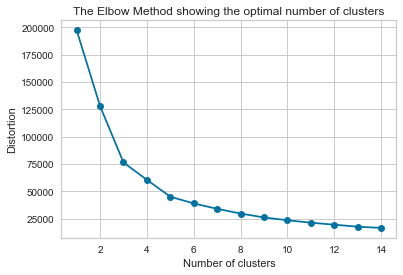

In [34]:
distortions=[]
for i in range(1,15):
    kmodel=KMeans(n_clusters=i,
                 n_init=5,
                 random_state=1)
    kmodel.fit(dfcs)
    distortions.append(kmodel.inertia_) 
    
plt.plot(range(1,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

Create the KMeans model with k = 4 clusters based on the elbow method.

In [35]:
kmodel=KMeans(n_clusters=4,n_init=5,random_state=1)
dfc["cluster_kmeans"] = kmodel.fit_predict(dfcs)

Create result table.

In [36]:
dfc_table=dfc.groupby('cluster_kmeans').agg(mean_frequency=pd.NamedAgg('frequency', 'mean'),
                                           mean_recency=pd.NamedAgg('recency', 'mean'),
                                           mean_monetary=pd.NamedAgg('monetary', 'mean'),
                                           cluster_size=pd.NamedAgg('cluster_kmeans','count')).reset_index()
dfc_table=dfc_table.round({"mean_frequency":1, "mean_recency":0, "mean_monetary":0})
dfc_table=dfc_table.astype({'mean_recency':'int', 'mean_monetary':'int'})
dfc_table

,cluster_kmeans,mean_frequency,mean_recency,mean_monetary,cluster_size
0,0,1.0,1727,101,53552
1,1,1.0,1988,102,39637
2,2,1.0,1843,1879,623
3,3,1.0,1831,617,4853


Interpetation of the results:

    cluster 0: low monetary and low recency
    
    cluster 1: high recency and low monetary
    
    cluster 2: high monetary and high recency
    
    cluster 3: medium monetary and recency 


## Second Model - Classification of Sellers

Importing all the libraries that we needed

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd 

Getting from the xlsx file the data that we needed. Then grouping by the columns needed to get the necessary info about the sellers.

In [38]:
#------------------------------------------------------------------------------------------------
df = pd.read_excel('olist.xlsx')
#------------------------------------------------------------------------------------------------
seller_frequency = df.groupby('Seller Dim.Seller Id')['Product Dim.Prod Id'].count()

seller_frequency = seller_frequency.to_frame(name='num_of_products_sold')
#------------------------------------------------------------------------------------------------
seller_profit = df.groupby('Seller Dim.Seller Id')['Price'].sum()

seller_profit = seller_profit.to_frame(name='profit')
#------------------------------------------------------------------------------------------------
seller_customer = df.groupby('Seller Dim.Seller Id')['Customer Dim.Cust Id'].unique()

seller_customer = seller_customer.to_frame(name='num_of_cust')

seller_customer['num_of_cust'] = seller_customer['num_of_cust'].str.len()
#------------------------------------------------------------------------------------------------
seller_info_df = seller_frequency.merge(seller_profit, how='left', on = 'Seller Dim.Seller Id')

seller_info_df = seller_info_df.merge(seller_customer, how='left', on = 'Seller Dim.Seller Id')

Starting the classification process

Getting the first 600 rows that have  the category column already filled (we filled them by hand) with the appropriate category (platinum, gold, silver). 

In [40]:
df = pd.read_excel('Classification_data.xlsx')

df_labeled = df.head(600)
X = df_labeled.iloc[:, :-1].values
y = df_labeled.iloc[:, 4].values 

We split the dataset into random train and test subsets.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle  = False) 

Then we standardize features by removing mean and scaling to unit variance

In [42]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

We use the KNN classifier to fit data and print the confusion matrix and classification report to see if the model we created is good.

In [43]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train) 

y_predict = classifier.predict(X_test)

print(confusion_matrix(y_test, y_predict))


[[16  0  8]
 [ 6  9  0]
 [ 2  0 79]]


In [44]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

        gold       0.67      0.67      0.67        24
    platinum       1.00      0.60      0.75        15
      silver       0.91      0.98      0.94        81

    accuracy                           0.87       120
   macro avg       0.86      0.75      0.79       120
weighted avg       0.87      0.87      0.86       120



Then we apply the model to the data that we don't have the column category already filled. More specifically we predict the 'categ' data with the classifier 

In [45]:
df_prediction = df.iloc[601:]
df_prediction = df_prediction.iloc[:, :-1].values

y_predict = classifier.predict(df_prediction)
y_predict = y_predict.tolist()
df_prediction=pd.DataFrame(df_prediction)
df_prediction["categ"] = y_predict
df_prediction

,0,1,2,3,categ
0,602.0,2.0,335.00,2.0,platinum
1,603.0,32.0,6731.15,32.0,platinum
2,604.0,12.0,1069.70,11.0,platinum
3,605.0,31.0,2718.00,31.0,platinum
4,606.0,31.0,3905.05,29.0,platinum
...,...,...,...,...,...
2489,3091.0,1.0,69.90,1.0,silver
2490,3092.0,18.0,2101.20,18.0,platinum
2491,3093.0,14.0,1839.86,14.0,platinum
2492,3094.0,60.0,9062.30,60.0,platinum
